# Problem Statement

Forecasting the future web traffic (webpage visits) of multiple time-series for Wikipedia webpages and analyzing the pattern of traffic to understand the web traffic more.

# Executive Summary

Wikipedia web traffic forecasting was challenging due to missing data and time-series length. However, when i inspected the data, i found that English webpages get more visits compared to other languages, and the type of day (weekend,weekday) does not make a big difference. When it came to modeling, i used ARMA to fit train/test the data but the MSE was high due to the size of the train/test data.  

# Basic EDA

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter


#Timeseries modeling imports
from statsmodels.tsa.arima_model import ARIMA, ARMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
websites = pd.read_csv('train_1.csv')

In [3]:
websites.head(10)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
7,A'N'D_zh.wikipedia.org_all-access_spider,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
8,AKB48_zh.wikipedia.org_all-access_spider,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
9,ASCII_zh.wikipedia.org_all-access_spider,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0


In [4]:
websites.shape

(145063, 551)

In [5]:
websites.isnull().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

In [63]:
#check null percentage
percentage_missing = (websites.isnull().sum().sum()/len(websites))
percentage_missing

42.69132032289419

In [7]:
websites_flattened = pd.melt(websites[list(websites.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
#check to delete columns or not
websites_flattened['date'] = websites_flattened['date'].astype('datetime64[ns]')
websites_flattened['weekend'] = ((websites_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [8]:
#examine data types
websites_flattened.dtypes

Page               object
date       datetime64[ns]
Visits            float64
weekend           float64
dtype: object

In [9]:
websites_flattened.head()

,Page,date,Visits,weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-12,13.0,1.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-12,12.0,1.0
2,3C_zh.wikipedia.org_all-access_spider,2016-11-12,6.0,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-11-12,38.0,1.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-11-12,13.0,1.0


In [10]:
websites_flattened.isnull().sum()

Page            0
date            0
Visits     199220
weekend         0
dtype: int64

In [13]:
#page language inspection
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

websites_flattened['lang'] = websites_flattened.Page.map(get_language)

print(Counter(websites_flattened.lang))

Counter({'en': 1205400, 'ja': 1021550, 'de': 927350, 'na': 892750, 'fr': 890100, 'zh': 861450, 'ru': 751100, 'es': 703450})


In [14]:
# Average by page
websites_mean = pd.DataFrame(websites_flattened.groupby(['Page'])['Visits'].mean())
websites_mean.columns = ['mean']

# Merging data
websites_flattened = websites_flattened.set_index('Page').join(websites_mean)

In [15]:
websites_flattened.reset_index(drop=False,inplace=True)

In [16]:
#splitting date into columns
websites_flattened['year']=websites_flattened.date.dt.year 
websites_flattened['month']=websites_flattened.date.dt.month 
websites_flattened['day']=websites_flattened.date.dt.day

In [17]:
websites_flattened.head()

,Page,date,Visits,weekend,lang,mean,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,en,2.836735,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,en,2.836735,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,en,2.836735,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,en,2.836735,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,en,2.836735,2016,11,16


In [77]:
websites_flattened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253150 entries, 0 to 7253149
Data columns (total 9 columns):
Page       object
date       datetime64[ns]
Visits     float64
weekend    float64
lang       object
mean       float64
year       int64
month      int64
day        int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 498.0+ MB


In [78]:
websites_flattened.describe()

,Visits,weekend,mean,year,month,day
count,7.053930e+06,7.253150e+06,7.191700e+06,7253150.0,7.253150e+06,7.253150e+06
mean,1.471910e+03,3.000000e-01,1.450476e+03,2016.0,1.162000e+01,1.790000e+01
std,8.208759e+04,4.582576e-01,8.057482e+04,0.0,4.853865e-01,8.178631e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,1.100000e+01,1.000000e+00
25%,2.200000e+01,0.000000e+00,2.428000e+01,2016.0,1.100000e+01,1.200000e+01
50%,1.580000e+02,0.000000e+00,1.914300e+02,2016.0,1.200000e+01,1.850000e+01
75%,6.860000e+02,1.000000e+00,8.073200e+02,2016.0,1.200000e+01,2.500000e+01
max,2.834288e+07,1.000000e+00,2.320080e+07,2016.0,1.200000e+01,3.100000e+01


# Data Visualization

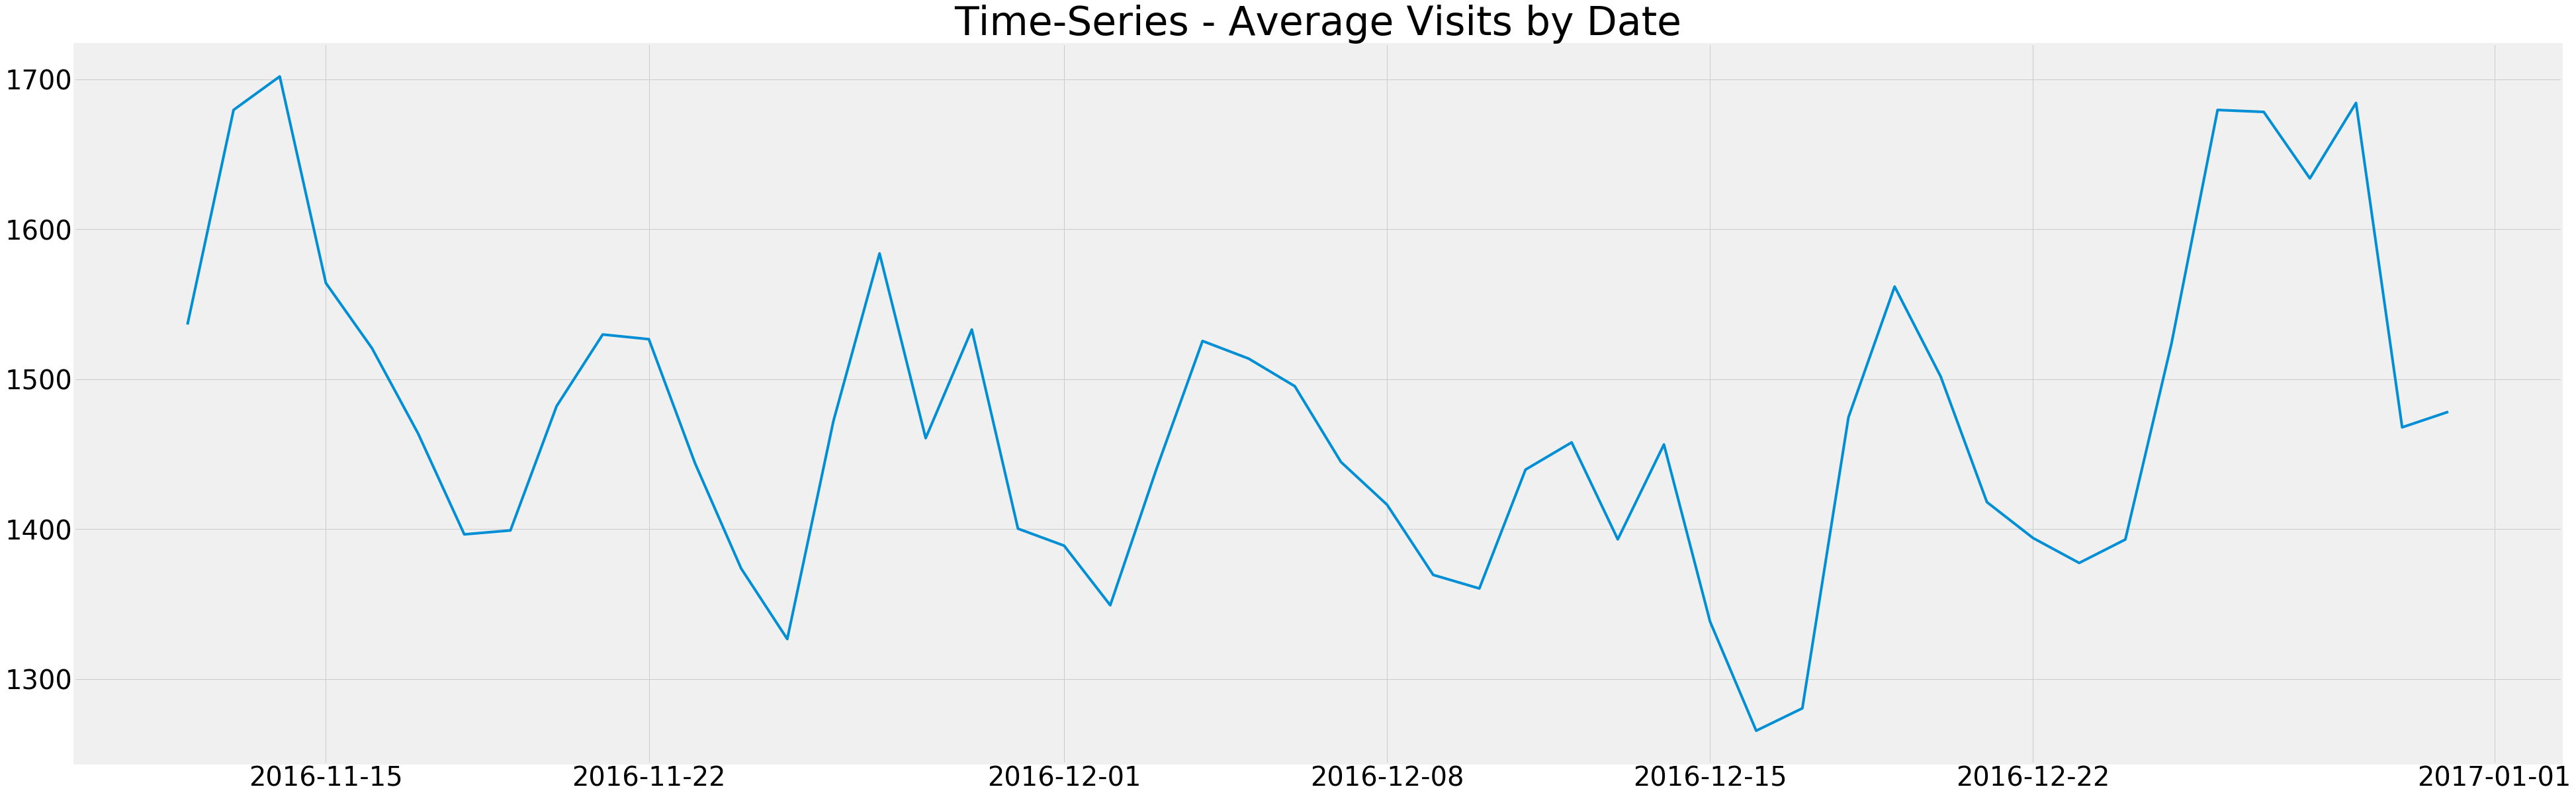

In [18]:
plt.figure(figsize=(60, 20))
mean_plt = websites_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_plt)
plt.title('Time-Series - Average Visits by Date',fontsize=60)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.show()

In [21]:
websites_flattened.year.unique()

array([2016])

In [22]:
by_dayofweek = websites_flattened[['Page','date','Visits','weekend']]

In [23]:
isweekend = by_dayofweek[by_dayofweek['weekend'] == 1.0]
notweekend = by_dayofweek[by_dayofweek['weekend'] == 0.0]

In [24]:
is_weekend = isweekend[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
#is_weekend = isweekend[['Page','Visits']].groupby(['date'])['Visits'].sum()

In [25]:
isnt_weekend = notweekend[['Page','date','Visits']].groupby(['date'])['Visits'].mean()

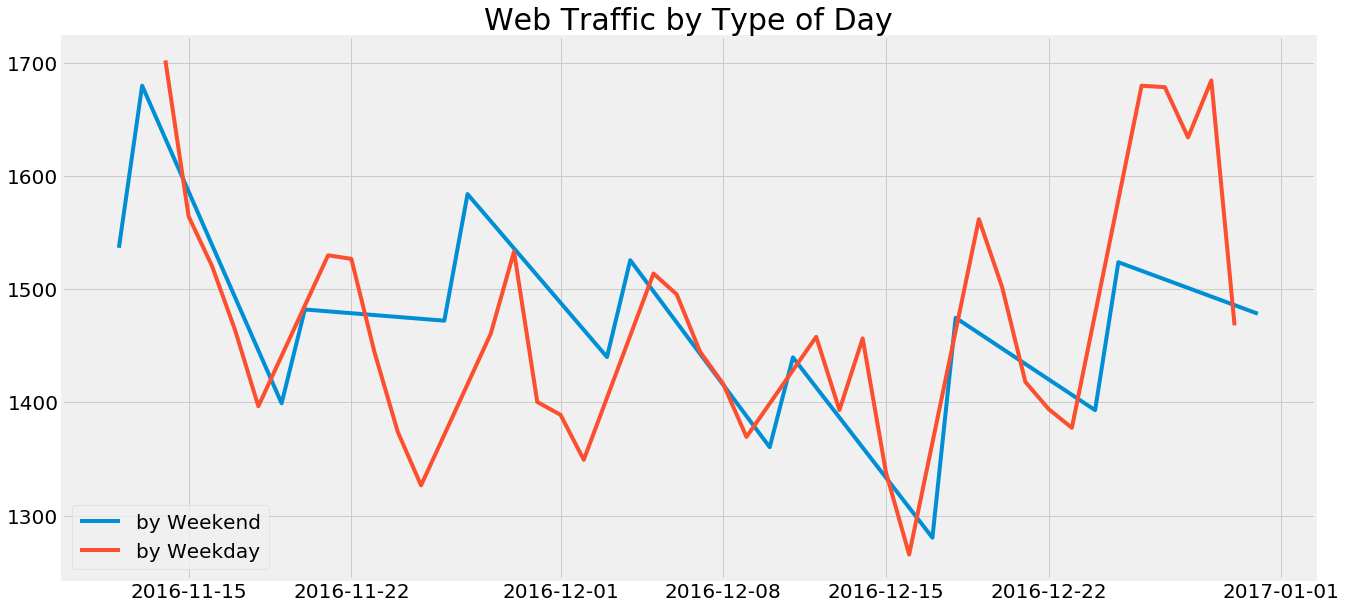

In [87]:
# Displaying cases by day
plt.figure(figsize=(20,10))
plt.plot(is_weekend,label='by Weekend');
plt.plot(isnt_weekend,label='by Weekday');
plt.title('Web Traffic by Type of Day',fontsize='30');
plt.yticks(fontsize='20')
plt.xticks(fontsize='20')
plt.legend(fontsize='20')


We can see that there is not much of a difference between traffic in weekdays and traffic in weekends.

### Is it influenced by language? 

In [117]:
lang_group = websites_flattened
lang_group[['lang']] = lang_group['lang'].map({'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       })

In [116]:
lang_group

,Page,date,Visits,weekend,lang,mean,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,en,2.836735,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,en,2.836735,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,en,2.836735,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,en,2.836735,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,en,2.836735,2016,11,16
...,...,...,...,...,...,...,...,...,...
7253145,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-27,2336.0,0.0,ja,3457.740000,2016,12,27
7253146,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-28,2455.0,0.0,ja,3457.740000,2016,12,28
7253147,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-29,3302.0,0.0,ja,3457.740000,2016,12,29
7253148,［Alexandros］_ja.wikipedia.org_mobile-web_all-a...,2016-12-30,2789.0,0.0,ja,3457.740000,2016,12,30


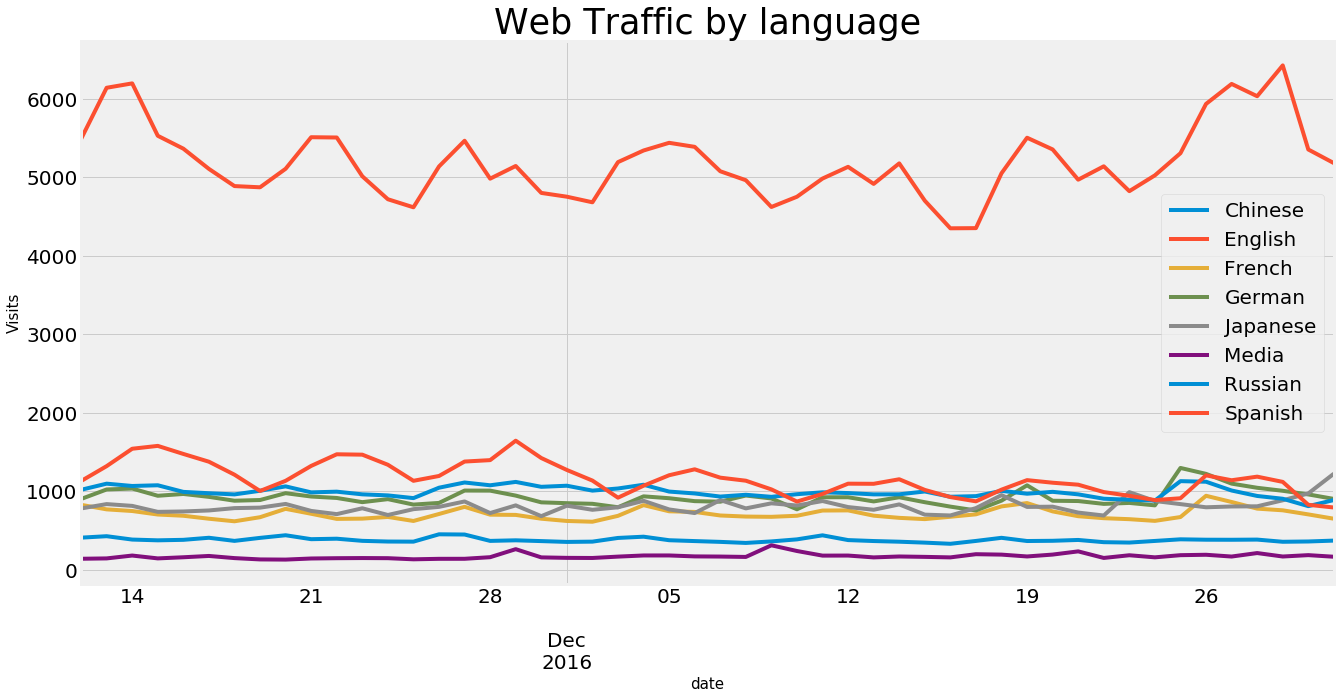

In [118]:
#plot by language
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(20,10))
lang_group.groupby(['date','lang']).mean()['Visits'].unstack().plot(ax=ax)
ax.tick_params(which='minor', labelsize=20)
plt.title('Web Traffic by language',fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Visits',fontsize='15')
plt.xlabel('date',fontsize='15')
plt.legend(fontsize=20)
plt.show()

In [30]:
websites_mean = websites_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
df_mean = pd.DataFrame(websites_mean.reset_index(drop=False))

# Data Modeling

### Autocorrelation:

In [35]:
X = df_mean[['Visits']]

In [36]:
acf(X['Visits'],nlags=20)

array([ 1.00000000e+00,  6.66653305e-01,  2.48123400e-01, -7.06188891e-02,
       -1.85291641e-01, -8.38357090e-02,  1.50352101e-01,  3.28528978e-01,
        2.29815435e-01, -3.22219018e-02, -2.55811944e-01, -3.37816286e-01,
       -2.37805651e-01, -6.62315184e-03,  1.35818474e-01,  1.35630147e-01,
       -9.47526700e-02, -2.27808629e-01, -2.85999967e-01, -2.04607143e-01,
       -7.64076928e-04])

In [37]:
#method to plot autocorrelation and partial autocorrelation
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

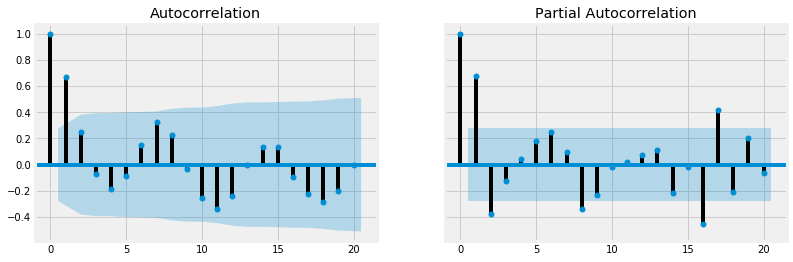

In [38]:
fig, ax = autocorr_plots(X['Visits'],lags=20)

### Seasonality Decomposition:

In [39]:
df_date_index = df_mean[['date','Visits']].set_index('date')

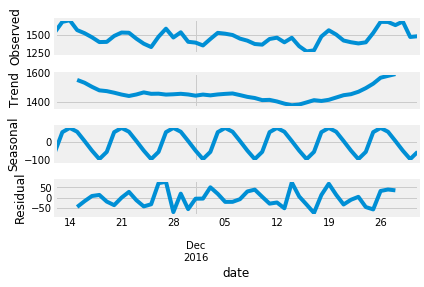

In [40]:
result = seasonal_decompose(df_date_index,freq=7).plot()

### Checking Stationarity: 

In [41]:
#H0: timeseries is non-stationary
result = adfuller(X['Visits'])
result

(-4.292838657147469,
 0.0004570692009995712,
 1,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 441.8450150253109)

In [42]:
p_value = result[1]
p_value

0.0004570692009995712

P value < 0.05 so we reject the null hypothesis, meaning our data is stationary.

### ARMA Modeling

In [43]:
df_date_index.index.max(),df_date_index.index.min()

(Timestamp('2016-12-31 00:00:00'), Timestamp('2016-11-12 00:00:00'))

In [44]:
df_train = df_date_index.loc[:'2016-12-24']
df_test = df_date_index.loc['2016-12-24':]

In [45]:
df_train.shape, df_test.shape

((43, 1), (8, 1))

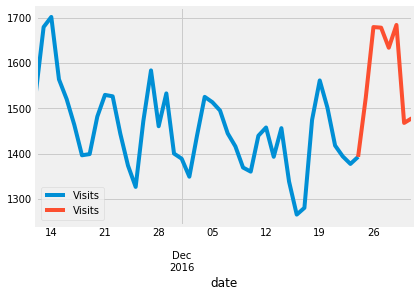

In [46]:
fig, ax = plt.subplots()
df_train.plot(label='train', ax=ax)
df_test.plot(label='test', ax=ax)
plt.show()

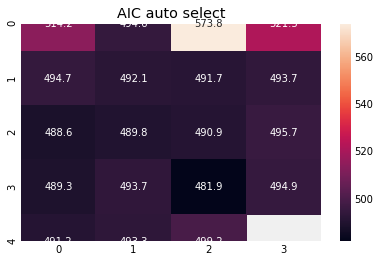

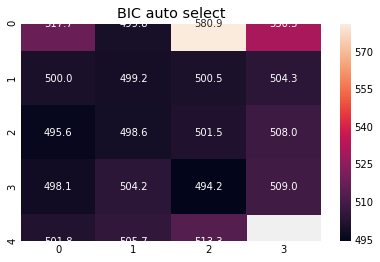

In [47]:
#AIC and BIC heatmaps
from statsmodels.tsa import stattools

auto_select = stattools.arma_order_select_ic(df_train, max_ar=4, max_ma=3, ic=['aic', 'bic'])


sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.title('AIC auto select')
plt.show()

sns.heatmap(auto_select['bic'], annot=True, fmt='.1f')
plt.title('BIC auto select')
plt.show()

In [48]:
model = ARMA(df_train,order=(3,2))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Visits   No. Observations:                   43
Model:                     ARMA(3, 2)   Log Likelihood                -233.931
Method:                       css-mle   S.D. of innovations             51.600
Date:                Mon, 13 Apr 2020   AIC                            481.861
Time:                        21:03:00   BIC                            494.190
Sample:                    11-12-2016   HQIC                           486.407
                         - 12-24-2016                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1457.9329     22.501     64.795      0.000    1413.832    1502.033
ar.L1.Visits     1.9655      0.144     13.641      0.000       1.683       2.248
ar.L2.Visits    -1.8814      0.177    -10.610      0.000      -2.229      -1.534
ar.L3.Visits     0.7030      0.150      4.696      0.000       0.410       0.996
ma.L1.Visits    -1.3694      0.116    -11.758      0.000      -1.598      -1.141
ma.L2.Visits     1.0000      0.094     10.657      0.000       0.816       1.184
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6341           -0.7798j            1.0051           -0.1413
AR.2            0.6341           +0.7798j            1.0051            0.1413
AR.3            1.4082           -0.0000j            1.4082           -0.0000
MA.1            0.6847           -0.7288j            1.0000           -0.1300
MA.2            0.6847           +0.7288j            1.0000            0.1300
-----------------------------------------------------------------------------
"""

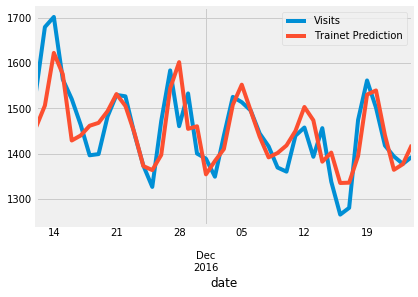

In [49]:
#plot our prediction for train data

df_train.plot(legend=True)
res.fittedvalues.rename('Trainet Prediction').plot(legend=True)
plt.show()

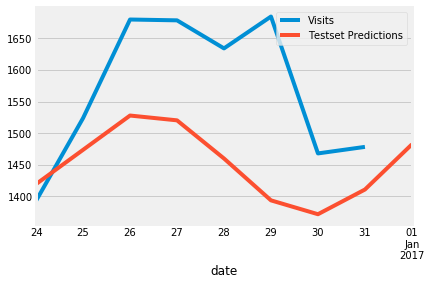

In [50]:
#plot our prediction for test data

start = len(df_train) - 1
end = len(df_train) + len(df_test) - 1

predictions = res.predict(start,end).rename('Testset Predictions')

#plot prediction and actual values
df_test.plot(legend=True)
predictions.plot(legend=True)


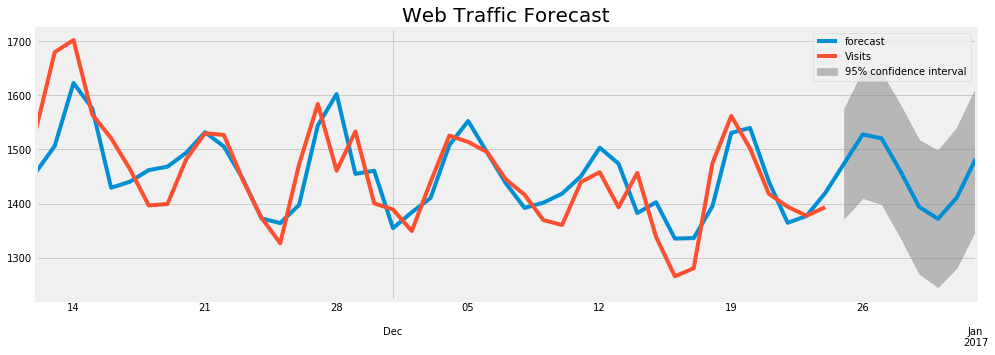

In [76]:
fig,ax = plt.subplots(figsize=(15,5))
res.plot_predict(start='2016',end='2017', ax=ax)
plt.title('Web Traffic Forecast',fontsize=20)
plt.show()

In [52]:
print('MSE statsmodels:\t', res.sigma2)

MSE statsmodels:	 2662.513867818264


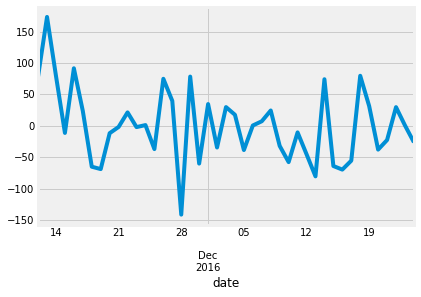

In [53]:
res.resid.plot()

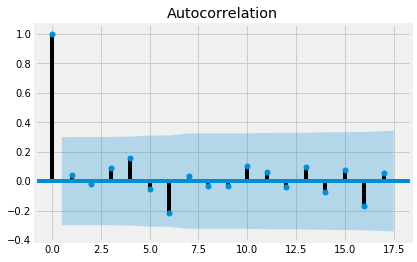

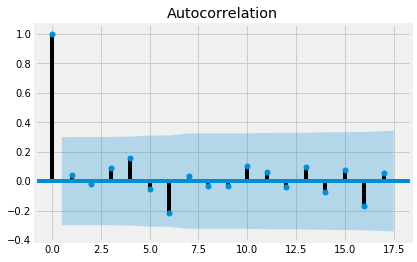

In [54]:
plot_acf(res.resid)

# Conclusion  

After analyzing the data i discovered a number of things: webpages drive more traffic if they are in English, there is not a dramatic difference in web traffic between weekdays and weekends, and traffic can be predictable if i had more data to work with, as the model is not reliable due to the size of trainig/testing data.